In [2]:
# Standard Library Imports
import re

# Third-Party Library Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel as t_test, wilcoxon
from scipy.stats import t
from math import sqrt
from statistics import stdev

In [3]:
def corrected_dependent_ttest(data1, data2, n_training_samples, n_test_samples, alpha):
    n = len(data1)
    differences = [(data1[i]-data2[i]) for i in range(n)]

    sd = stdev(differences)
    divisor = 1 / n * sum(differences)
    test_training_ratio = n_test_samples / n_training_samples  
    denominator = sqrt(1 / n + test_training_ratio) * sd
    t_stat = divisor / denominator
    # degrees of freedom
    df = n - 1
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    # calculate the p-value
    p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
    # return everything
    return t_stat, df, cv, p

In [4]:
def boxplot_scores(df, xsize, ysize, title):

    df = df.drop_duplicates('Classifier')
    
    df = df.explode('30 Folds Accuracy')

    plt.figure(figsize=(xsize, ysize))
    sns.boxplot(data=df, y='Classifier', x='30 Folds Accuracy', orient='h')

    plt.title('')
    plt.ylabel('')
    plt.tight_layout()

    plt.savefig(f'{title}', dpi=300)
    plt.show()

In [5]:
def compare_results(df):
    d = {}
    for i, row in df.iterrows():
        row_Classificador = row['Classifier']
        row_scores = row['30 Folds Accuracy']
        d[row_Classificador] = []
        for j, col in df.iterrows():
            col_Classificador = col['Classifier']
            col_scores = col['30 Folds Accuracy']

            if row_Classificador == col_Classificador:
                d[row_Classificador].append(col_Classificador)
            if i > j:
                _, _, _, p_value_t  = corrected_dependent_ttest(row_scores, col_scores,415*0.9,415*0.1,0.95)
                #_,p_value_t = t_test(row_scores, col_scores)
                d[row_Classificador].append(p_value_t)
            if i < j:
                _, p_value_w = wilcoxon(row_scores, col_scores)
                d[row_Classificador].append(p_value_w)

    df_testes = pd.DataFrame(d)
    df_testes.set_index(df_testes.columns, inplace=True)
    df_testes = df_testes.applymap(lambda x: format(x, '.3f') if isinstance(x, float) else x)

    return df_testes

In [6]:
def load_dataframe(path):
    # Carrega o dataframe
    df = pd.read_csv(path)
    
    # Modifica o nome das colunas
    new_column_names = {
        'scaler': 'Scaler',
        'classifier': 'Classifier',
        'params': 'Hyperparameters',
        'accuracy std': 'Accuracy\n(Std)',
        'accuracy': 'Accuracy',
        'roc_auc_ovr': 'ROC AUC OvR\n(Macro)',
        'f1_macro': 'F1 Score (Macro)',
        'recall_macro': 'Recall (Macro)',
        'accuracy_scores': '30 Folds Accuracy',
    }
    df.rename(columns=new_column_names, inplace=True)
    
    # Converte NoneType para 'None'
    df = df.where(pd.notna(df), 'None')
    
    # Modifica os Hiperparâmetros
    df['Hyperparameters'] = df['Hyperparameters'].apply(lambda x: 'Standard' if x == '{}' else 'Adjusted')
    
    # Modifica os Redimensionadores
    df['Scaler'] = df['Scaler'].apply(lambda x: 'Z-Score' if x == 'Standard' else '-')
    
    # Formatar colunas do tipo float
    #df[df.select_dtypes(float).columns] = df[df.select_dtypes(float).columns].map('{:.3f}'.format)
    df[df.select_dtypes(int).columns] = df[df.select_dtypes(int).columns].astype(str)
    
    # Converte os valores internos da lista de acurácias para float para plotar
    def convert_scores(row):
        numeric_values = re.findall(r'\d+\.\d+', row)
        float_list = [float(value) for value in numeric_values]
        return float_list

    df['30 Folds Accuracy'] = df['30 Folds Accuracy'].apply(convert_scores)
    return df

In [7]:
all_default_results = load_dataframe('df_all_default_results.csv')
all_default_results.columns

Index(['Scaler', 'Classifier', 'Hyperparameters', 'Accuracy\n(Std)',
       'Accuracy', 'ROC AUC OvR\n(Macro)', 'F1 Score (Macro)',
       'Recall (Macro)', '30 Folds Accuracy'],
      dtype='object')

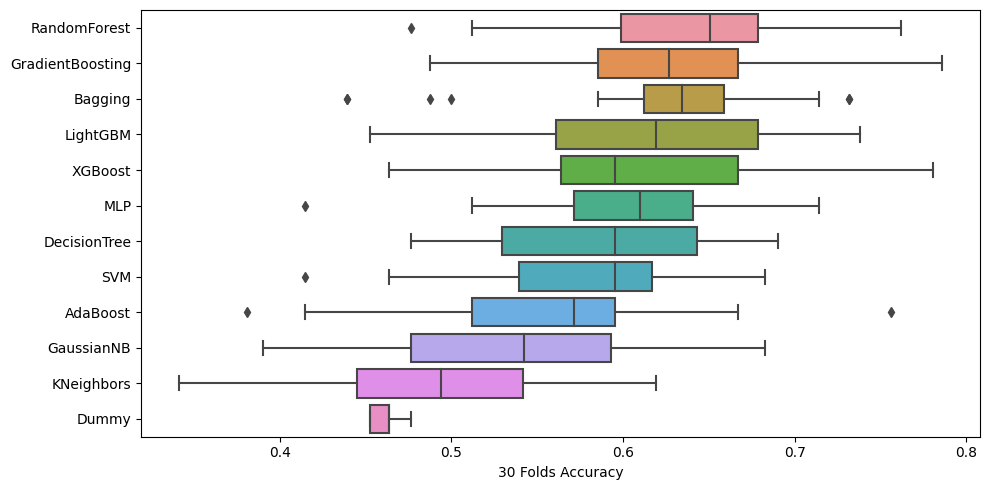

In [8]:
title = 'Resultados dos 10 modelos com hiperparametros padrao'
boxplot_scores(all_default_results, 10, 5, title=f'Boxplot - {title}')

In [9]:
all_default_results = all_default_results[all_default_results['Scaler'] == "Z-Score"]
all_default_results

,Scaler,Classifier,Hyperparameters,Accuracy\n(Std),Accuracy,ROC AUC OvR\n(Macro),F1 Score (Macro),Recall (Macro),30 Folds Accuracy
1,Z-Score,RandomForest,Standard,0.074401,0.641696,0.756103,0.540879,0.543627,"[0.66666667, 0.64285714, 0.61904762, 0.6666666..."
2,Z-Score,GradientBoosting,Standard,0.068989,0.623790,0.735612,0.551431,0.548359,"[0.69047619, 0.61904762, 0.64285714, 0.7142857..."
4,Z-Score,Bagging,Standard,0.071305,0.622280,0.725418,0.534433,0.537961,"[0.69047619, 0.69047619, 0.61904762, 0.6190476..."
8,Z-Score,XGBoost,Standard,0.080690,0.611963,0.755442,0.540175,0.537943,"[0.69047619, 0.52380952, 0.57142857, 0.6904761..."
9,Z-Score,LightGBM,Standard,0.078620,0.604530,0.742532,0.521414,0.523356,"[0.66666667, 0.57142857, 0.61904762, 0.6666666..."
10,Z-Score,MLP,Standard,0.063810,0.601413,0.677539,0.494554,0.508636,"[0.61904762, 0.64285714, 0.64285714, 0.6428571..."
11,Z-Score,DecisionTree,Standard,0.067890,0.593419,0.669237,0.544831,0.552560,"[0.57142857, 0.54761905, 0.64285714, 0.6666666..."
13,Z-Score,SVM,Standard,0.065609,0.577274,0.644253,0.417032,0.459635,"[0.61904762, 0.64285714, 0.5952381, 0.5952381,..."
15,Z-Score,AdaBoost,Standard,0.074609,0.557375,0.641285,0.477084,0.480195,"[0.47619048, 0.57142857, 0.52380952, 0.5714285..."
18,Z-Score,KNeighbors,Standard,0.061810,0.486605,0.567844,0.383259,0.397845,"[0.47619048, 0.42857143, 0.47619048, 0.5952381..."


In [14]:
all_default_results[["Classifier","Accuracy","Accuracy\n(Std)","ROC AUC OvR\n(Macro)","F1 Score (Macro)","Recall (Macro)"]].to_latex()

'\\begin{tabular}{llrrrrr}\n\\toprule\n & Classifier & Accuracy & Accuracy\n(Std) & ROC AUC OvR\n(Macro) & F1 Score (Macro) & Recall (Macro) \\\\\n\\midrule\n1 & RandomForest & 0.641696 & 0.074401 & 0.756103 & 0.540879 & 0.543627 \\\\\n2 & GradientBoosting & 0.623790 & 0.068989 & 0.735612 & 0.551431 & 0.548359 \\\\\n4 & Bagging & 0.622280 & 0.071305 & 0.725418 & 0.534433 & 0.537961 \\\\\n8 & XGBoost & 0.611963 & 0.080690 & 0.755442 & 0.540175 & 0.537943 \\\\\n9 & LightGBM & 0.604530 & 0.078620 & 0.742532 & 0.521414 & 0.523356 \\\\\n10 & MLP & 0.601413 & 0.063810 & 0.677539 & 0.494554 & 0.508636 \\\\\n11 & DecisionTree & 0.593419 & 0.067890 & 0.669237 & 0.544831 & 0.552560 \\\\\n13 & SVM & 0.577274 & 0.065609 & 0.644253 & 0.417032 & 0.459635 \\\\\n15 & AdaBoost & 0.557375 & 0.074609 & 0.641285 & 0.477084 & 0.480195 \\\\\n18 & KNeighbors & 0.486605 & 0.061810 & 0.567844 & 0.383259 & 0.397845 \\\\\n21 & Dummy & 0.462660 & 0.008282 & 0.500000 & 0.210861 & 0.333333 \\\\\n22 & GaussianNB & 0

In [16]:
#compare only top 3
compare_results(all_default_results.iloc[:3])

/home/vbbonella/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,RandomForest,GradientBoosting,Bagging
RandomForest,RandomForest,0.401,0.348
GradientBoosting,0.137,GradientBoosting,0.951
Bagging,0.057,0.959,Bagging
